In [1]:
import weka.core.jvm as jvm
import wrapper

# python-weka-wrapper를 사용하기 위한 jvm 실행
# jvm이 다시 시작이 안되는 경우 커널을 재시작 해주세요
jvm.start()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/opt/conda/envs/py36/lib/python3.6/site-packages/javabridge/jars/rhino-1.7R4.jar', '/opt/conda/envs/py36/lib/python3.6/site-packages/javabridge/jars/runnablequeue.jar', '/opt/conda/envs/py36/lib/python3.6/site-packages/javabridge/jars/cpython.jar', '/opt/conda/envs/py36/lib/python3.6/site-packages/weka/lib/weka.jar', '/opt/conda/envs/py36/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


# 모델 학습
- 선형회귀
- 랜덤 포레스트
- SMOreg

In [2]:
# train, test 데이터 불러오기
from weka.classifiers import Classifier

dfile_train = "./datasets/housing_train.arff"
dfile_test = "./datasets/housing_test.arff"
data_train = wrapper.load_data(dfile_train)
data_test = wrapper.load_data(dfile_test)

## 선형회귀 모델 학습

In [3]:
# 선형 분류기 객체 생성
linear = Classifier(classname="weka.classifiers.functions.LinearRegression")

# 학습 데이터로 선형 분류기 학습
linear.build_classifier(data_train)

# 선형 분류기 학습 결과
print(linear)


Linear Regression Model

MEDV =

     -0.115  * CRIM +
      0.0537 * ZN +
      3.3236 * CHAS=1 +
    -19.12   * NOX +
      3.6307 * RM +
     -1.6234 * DIS +
      0.3724 * RAD +
     -0.0152 * TAX +
     -0.9835 * PTRATIO +
      0.0083 * B +
     -0.5271 * LSTAT +
     40.518 


## 랜덤 포레스트 모델 학습

In [4]:
# 랜덤 포레스트 분류기 객체 생성
rf = Classifier(classname="weka.classifiers.trees.RandomForest")

# 학습 데이터로 랜덤 포레스트 학습
rf.build_classifier(data_train)
print(rf)

RandomForest

Bagging with 100 iterations and base learner

weka.classifiers.trees.RandomTree -K 0 -M 1.0 -V 0.001 -S 1 -do-not-check-capabilities


## SMOreg 모델 학습
- somreg: 모든 특징 적용

In [5]:
# smoreg 모든 특징 적용
from weka.classifiers import KernelClassifier
from weka.classifiers import Kernel

# smo 분류기 객체 생성
smoreg = KernelClassifier(classname="weka.classifiers.functions.SMOreg")

# RBF의 감마(1/(2*분산)) 을 3로 변경  (실험을 통해 적절한 인자 찾음)
kernel = Kernel(classname="weka.classifiers.functions.supportVector.RBFKernel", options=["-G", "3"])
smoreg.kernel = kernel

smoreg.build_classifier(data_train)
#print(smoreg) # 인자가 많아서 보기가 힘듬

- smoreg_cfs: CFS 후진 제거 방법 적용

In [6]:
# smogreg CFS 후진 제거 방법을 적용
from weka.attribute_selection import ASSearch
from weka.attribute_selection import ASEvaluation

# 탐색: BestFirst (backward) 방법, 평가: CFS
search = ASSearch(classname="weka.attributeSelection.BestFirst", options=['-D', '0'])
evaluator = ASEvaluation(classname="weka.attributeSelection.CfsSubsetEval")

# smoreg 객체 생성 (commandline을 가져오기 위한 용도)
smoreg_wrapper = KernelClassifier(classname="weka.classifiers.functions.SMOreg")
kernel = Kernel(classname="weka.classifiers.functions.supportVector.RBFKernel", options=["-G", "2"])
smoreg_wrapper.kernel = kernel

# 특징 추출 search(탐색)과 evaluator(평가 방법), cls(분류기)로 부터 특징 추출 후 분류하는 분류기 객체 반환
def asClassifier(search, evaluator, cls):
    options = ['-E', evaluator.to_commandline(), '-S', search.to_commandline()] + \
              ['-W', cls.classname, '--', *cls.options]

    return Classifier(classname='weka.classifiers.meta.AttributeSelectedClassifier',
                      options=options)


# CFS 후진 제거 방법으로 특징 선택 후, SMOreg 분류기를 수행하는 객체 생성
smoreg_cfs = asClassifier(search, evaluator, smoreg_wrapper)

# 학습 데이터로 분류기 학습
smoreg_cfs.build_classifier(data_train)

----------

----------

----------

# 모델 평가
- 선형회귀
- 랜덤 포레스트
- SMOreg, SMOreg with CFS

## 선형회귀 모델 평가


Correlation coefficient                  0.8819
Mean absolute error                      3.0827
Root mean squared error                  4.222 
Relative absolute error                 47.0767 %
Root relative squared error             47.4721 %
Total Number of Instances              152     

        1     18.5       19.388      0.888 
        2     34.9       29.976     -4.924 
        3     22         27.273      5.273 
        4     23.2       22.319     -0.881 
        5     24.7       24.714      0.014 
        6     28.4       28.676      0.276 
        7     42.8       29.165    -13.635 
        8     22         20.819     -1.181 
        9     22         25.746      3.746 
       10     15.1       17.139      2.039 
       11     20.1       18.533     -1.567 
       12     14.4        9.01      -5.39  
       13     41.3       32.835     -8.465 
       14     43.8       34.937     -8.863 
       15     24.6       24.427     -0.173 
       16     17.5       16.612     -0.888 
  

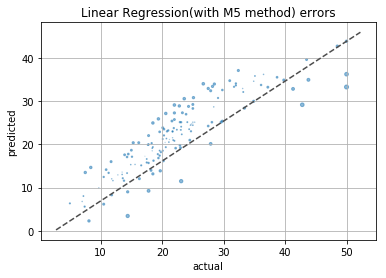

In [7]:
from weka.classifiers import Evaluation
from weka.classifiers import PredictionOutput

# 결과 출력을 평문으로 출력하게 하는 객체 선언
# 주어지는 데이터를 평가하는 객체 선언
# 학습한 선형 회귀 모델과 테스트 데이터 평가
pout = PredictionOutput(classname="weka.classifiers.evaluation.output.prediction.PlainText")
evl = Evaluation(data_test)
evl.test_model(linear, data_test, pout)

# 모델 평가 측도 출력
print(evl.summary())
#  inst#(번호)     actual(실제)  predicted(예측)      error(오차)   출력
print(pout.buffer_content())

# 학습한 모델로 x축 실제 데이터, y축 예측값 그린 그래프, outfile에 그림 파일 생성
import weka.plot.classifiers as plcls
plcls.plot_classifier_errors(evl.predictions,
                             wait=True, 
                             title='Linear Regression(with M5 method) errors',
                             outfile='Linear Regression.svg')

## 랜덤 포레스트 모델 평가


Correlation coefficient                  0.9516
Mean absolute error                      2.1429
Root mean squared error                  2.8268
Relative absolute error                 32.7702 %
Root relative squared error             31.783  %
Total Number of Instances              152     

        1     18.5       19.643      1.143 
        2     34.9       31.385     -3.515 
        3     22         26.312      4.312 
        4     23.2       19.828     -3.372 
        5     24.7       24.801      0.101 
        6     28.4       27.031     -1.369 
        7     42.8       37.343     -5.457 
        8     22         21.463     -0.537 
        9     22         23.609      1.609 
       10     15.1       13.947     -1.153 
       11     20.1       18.748     -1.352 
       12     14.4       18.845      4.445 
       13     41.3       33.275     -8.025 
       14     43.8       41.99      -1.81  
       15     24.6       24.812      0.212 
       16     17.5       18.399      0.899 
  

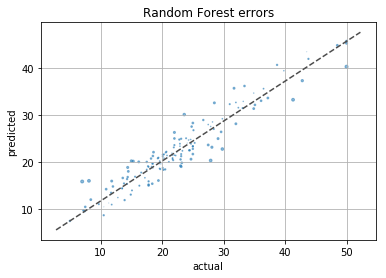

In [8]:
# 분류기가 랜덤포레스트인 것을 제외하고 선형 회귀와 동일
from weka.classifiers import Evaluation
from weka.classifiers import PredictionOutput

pout = PredictionOutput(classname="weka.classifiers.evaluation.output.prediction.PlainText")
evl = Evaluation(data_train)
evl.test_model(rf, data_test, pout)

print(evl.summary())
print(pout.buffer_content())

import weka.plot.classifiers as plcls
plcls.plot_classifier_errors(evl.predictions,
                             wait=True,
                             title='Random Forest errors',
                             outfile='Random Forest.svg')

## SMOreg 모델 평가


Correlation coefficient                  0.9622
Mean absolute error                      1.9082
Root mean squared error                  2.4383
Relative absolute error                 29.1811 %
Root relative squared error             27.4155 %
Total Number of Instances              152     

        1     18.5       17.315     -1.185 
        2     34.9       31.297     -3.603 
        3     22         26.208      4.208 
        4     23.2       21.241     -1.959 
        5     24.7       22.689     -2.011 
        6     28.4       25.18      -3.22  
        7     42.8       35.468     -7.332 
        8     22         19.892     -2.108 
        9     22         22.672      0.672 
       10     15.1       14.039     -1.061 
       11     20.1       21.162      1.062 
       12     14.4       15.201      0.801 
       13     41.3       38.059     -3.241 
       14     43.8       43.078     -0.722 
       15     24.6       24.64       0.04  
       16     17.5       16.788     -0.712 
  

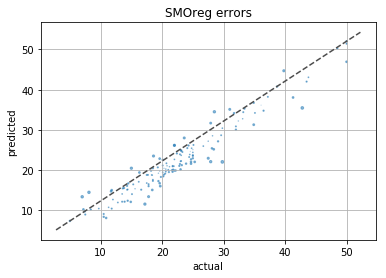

In [9]:
# 선형 회귀와 동일
from weka.classifiers import Evaluation
from weka.classifiers import PredictionOutput

pout = PredictionOutput(classname="weka.classifiers.evaluation.output.prediction.PlainText")
evl = Evaluation(data_train)
evl.test_model(smoreg, data_test, pout)

print(evl.summary())
print(pout.buffer_content())

import weka.plot.classifiers as plcls
plcls.plot_classifier_errors(evl.predictions,
                             wait=True,
                             title='SMOreg errors',
                             outfile='SMOreg errors.svg')

## SMOreg: CFS 후진 제거 방법 적용


Correlation coefficient                  0.9571
Mean absolute error                      1.9829
Root mean squared error                  2.6041
Relative absolute error                 30.3239 %
Root relative squared error             29.2796 %
Total Number of Instances              152     

        1     18.5       17.582     -0.918 
        2     34.9       31.873     -3.027 
        3     22         25.737      3.737 
        4     23.2       20.837     -2.363 
        5     24.7       24.879      0.179 
        6     28.4       26.931     -1.469 
        7     42.8       41.194     -1.606 
        8     22         19.221     -2.779 
        9     22         22.575      0.575 
       10     15.1       14.31      -0.79  
       11     20.1       19.924     -0.176 
       12     14.4       17.934      3.534 
       13     41.3       34.554     -6.746 
       14     43.8       42.027     -1.773 
       15     24.6       26.106      1.506 
       16     17.5       16.769     -0.731 
  

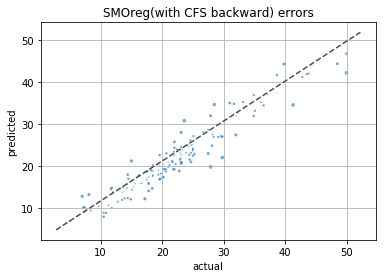

In [10]:
# 선형 회귀와 동일
from weka.classifiers import Evaluation
from weka.classifiers import PredictionOutput

pout = PredictionOutput(classname="weka.classifiers.evaluation.output.prediction.PlainText")
evl = Evaluation(data_train)
evl.test_model(smoreg_cfs, data_test, pout)

print(evl.summary())
print(pout.buffer_content())

import weka.plot.classifiers as plcls
plcls.plot_classifier_errors(evl.predictions,
                             wait=True,
                             title='SMOreg(with CFS backward) errors',
                             outfile='SMOreg2.svg')

In [11]:
# jvm 종료, jvm이 다시 시작이 안되는 경우 커널을 재시작 해주세요
jvm.stop()